# Phase and group delay

In [1]:
%run ../setup.ipynb

In the previous section, we saw how to investigate the properties of a convolutional filter $h$ by examining its frequency response, that is, the magnitude of its DFT $|H|$.
Examining the magnitude tells us an important part of the story, since it directly encapsulates the gain applied to each frequency when the filter is applied to a signal.
However, it's not the entire story: phase is also important!

Recall that the convolution theorem converts time-domain convolution into frequency-domain multiplication:

```{math}
y = h * x \quad\quad \Leftrightarrow \quad\quad Y[m] = H[m] \cdot X[m]
```

Since each $H[m]$ is a complex number, we can express it as $H[m] = A \cdot e^{\mathrm{j}\phi}$ for magnitude $A$ and phase $\phi$.
This tells us that the output DFT component $Y[m]$ will be derived from $X[m]$ by scaling (multiply by $A$) and rotation by angle $\phi$:

```{math}
Y[m] = H[m] \cdot X[m] = A \cdot e^{\mathrm{j}\phi} \cdot X[m].
```

From the {ref}`DFT shifting theorem <shifting-theorem>`, we know that applying delay to a signal results in a rotation of each DFT component $X[m]$, so we can interpret the rotation by $\phi$ as implementing a delay of the $m$th sinusoid.
The shifting theorem states precisely how this works: a delay of $k$ samples induces a rotation of $-2\pi\cdot k \cdot m / N$ for frequency index $m$ with signal length $N$, so that each frequency is rotated by an angle that depends on both the delay $k$ and the frequency index $m$.

However, there's no guarantee that an arbitrary filter $H$ will adhere to this structure!
Depending on the phase structure of $H$, the resulting signal could sound completely distorted.
Analyzing the phase structure of $H$ can reveal the presence of these distortions. 

## Examples

Before going into analyzing filter phase, it will help to have some intuitive grasp of how important phase is to a signal.

The examples below demonstrate filters which do not affect the magnitude spectrum at all: $|Y[m]| = |X[m]|$, but the output signal $y = h*x$ is substantially different from the input signal $x$.

### Example 1: discarding phase

To demonstrate the importance of phase, we can listen to what happens when we discard all phase information in a signal, so that 

```{math}
Y[m] = |X[m]|
```
This is equivalent to applying a filter with unit amplitude and phase exactly opposite of $X[m]$:

```{math}
H[m] = \frac{\overline{X[m]}}{|X[m]|}.
```

This can be implemented in Python as follows:
```{code-block} python
# Take the DFT
X = np.fft.rfft(x)

# Discard phase
Y = np.abs(X)

# Invert the DFT
y = np.fft.irfft(Y)
```

and the results are demonstrated below.

In [328]:
import soundfile as sf
from IPython.display import Audio, display

# https://freesound.org/s/50712/
x, fs = sf.read('50712__rutgermuller__drums-breakbeat-1.wav')
N = len(x)

In [329]:
X = np.fft.rfft(x)
y = np.fft.irfft(np.abs(X))

In [330]:
display('Original signal: https://freesound.org/s/50712')
display(Audio(data=x, rate=fs))
display('After removing phase')
display(Audio(data=y, rate=fs))

'Original signal: https://freesound.org/s/50712'

'After removing phase'

Discarding phase information preserves some aspects of the signal: the same frequencies are generally present, but the temporal coherence of the signal has been completely destroyed.

### Example 2: random phase

The example above is particularly bad, but by no means unique.
As a second example, we can imagine creating a filter $H$ with *random phases* between 0 and $2\pi$.

```{code-block} python

# get the length and DFT of a signal x
N = len(x)
X = np.fft.rfft(x)

# random(N) makes N random numbers between 0 and 1
# multiplying by 2pi gives us random phases
phase = np.random.random(N) * 2 * np.pi
H = np.exp(1j * phase)

# Rotate each X[m] by a random amount
Y = X * H

# recover the time-domain signal
y = np.fft.irfft(Y)
```

The result of this transformation is demonstrated below.

In [331]:
# Generate random phases between 0 and 2pi
phase = np.random.random(len(X)) * 2 * np.pi

# Create the filter
H = np.exp(1j * phase)

# Apply phases to Y
Y = X * H

# Recover the time-domain signal
y = np.fft.irfft(Y)

In [332]:
display('Random phase')
display(Audio(data=y, rate=fs))

'Random phase'

In this case, randomizing the phase has rendered the original signal completely unintelligible.

**Phase is important!**

## The phase spectrum

Let $H$ denote the DFT spectrum of an impulse response $h$.
Rather than plot the magnitude spectrum $|H|$, the **phase spectrum** is the sequence of phases $\phi_m$, where

```{math}
H[m] = A[m] \cdot e^{\mathrm{j} \phi[m]}.
```

In Python, the phase spectrum can be obtained as follows:

```{code-block} python
# Take the DFT of the filter
H = np.fft.fft(h)

# Extract the angle: between -pi and +pi
phase = np.angle(H)
```

Plotting $\phi_m$ as a sequence can help us understand the delay behavior of the filter for each analysis frequency $m$.
However, correctly interpreting the phase spectrum requires a bit more care than interpreting the magnitude spectrum.

### Example: delay filters

If we interpret delay as a convolutional filter, we can plot the phase spectrum of different delays to see what happens.
Some examples are displayed below in {numref}`delay-angle`.

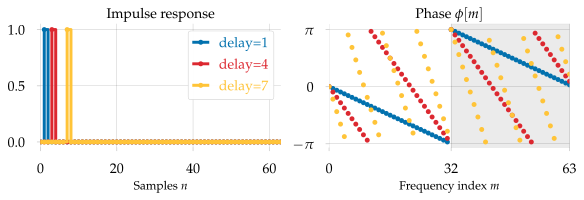

In [333]:
fig, (axt, axf) = plt.subplots(ncols=2, figsize=figaspect(1./3))

N = 64

d1 = np.zeros(N)
d1[1] = 1

d3 = np.zeros(N)
d3[3] = 1

d5 = np.zeros(N)
d5[7] = 1

n = np.arange(N)

axt.step(n, d1, label='delay=1', marker='.', where='post')
axt.step(n, d3, label='delay=4', marker='.', where='post')
axt.step(n, d5, label='delay=7', marker='.', where='post')
axt.legend(loc='upper right', labelcolor='linecolor')
axt.set(xlabel='Samples $n$', title='Impulse response')
D1 = np.fft.fft(d1)
D3 = np.fft.fft(d3)
D5 = np.fft.fft(d5)

axf.plot(np.angle(D1), label='delay=1', linestyle='', marker='.')
axf.plot(np.angle(D3), label='delay=4', linestyle='', marker='.')
axf.plot(np.angle(D5), label='delay=7', linestyle='', marker='.')
axf.set(yticks=[-np.pi, 0, np.pi], yticklabels=[r'$-\pi$', 0, r'$\pi$'])
axf.set(xticks=[0, N/2, N-1])
axf.set(xlabel='Frequency index $m$', title=r'Phase $\phi[m]$')
axf.axvspan(N/2, N-1, color=colors[3], alpha=0.1, zorder=-1)
glue('delay-angle', fig, display=False)

```{glue:figure} delay-angle
:name: delay-angle

**Left**: three different delay filters (1, 4, and 7 samples) are plotted with length $N=64$.
**Right**: for each filter, the phase spectrum is plotted as a function of frequency.
```

From {numref}`delay-angle`, we can observe that the different delay values make zig-zag shapes with different slopes.
This is exactly what is predicted by the DFT shifting theorem, which implies

```{math}
:label: phase-shift

\phi[m] = -2\pi \cdot \frac{k}{N}\cdot m
```

for a $k$-sample delay.  When plotted as a function of $m$, $\phi[m]$ should produce a line with slope $-2\pi \cdot k / N$, but this is not exactly what we see!

The zig-zag effect is due to angles wrapping around at $\pm\pi$.
The `np.angle` function extracts the angle from a complex number, but there are ambiguities in how angle is interpreted.
Remember that $\theta \equiv \theta + 2\pi$ for any angle $\theta$, so `np.angle` will always take the equivalent angle that lies within the range $[-\pi, +\pi)$.

This effect can be undone by using the `np.unwrap` function.
Angle unwrapping takes a sequence of angles $\phi[m]$ and produces a sequence of equivalent angles $\phi'[m]$ that avoid large discontinuities (greater than $\pi$ radians) between $\phi[m]$ and $\phi[m+1]$ by adding multiples of $2\pi$.
The unwrapped angles will land outside the $\pm\pi$ range, but satisfy $\phi'[m] = \phi[m] + c\cdot 2\pi$ (for some integer $c$).

In code, this is done as follows:

```{code-block} python
# Extract the angle: between -pi and +pi
phase = np.angle(H)

# Unwrap the phase
phase_unwrap = np.unwrap(phase)
```
The results of phase unwrapping on the delay filters in {numref}`delay-angle` are illustrated below.

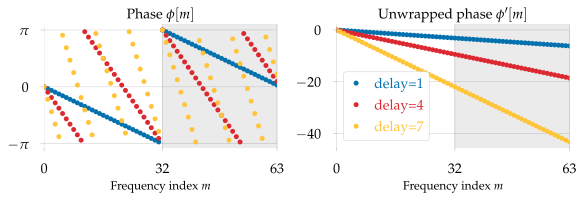

In [334]:
fig, (axf, axfun) = plt.subplots(ncols=2, figsize=figaspect(1./3))

N = 64

d1 = np.zeros(N)
d1[1] = 1

d3 = np.zeros(N)
d3[3] = 1

d5 = np.zeros(N)
d5[7] = 1

n = np.arange(N)

D1 = np.fft.fft(d1)
D3 = np.fft.fft(d3)
D5 = np.fft.fft(d5)

axf.plot(np.angle(D1), label='delay=1', linestyle='', marker='.')
axf.plot(np.angle(D3), label='delay=4', linestyle='', marker='.')
axf.plot(np.angle(D5), label='delay=7', linestyle='', marker='.')
axf.set(yticks=[-np.pi, 0, np.pi], yticklabels=[r'$-\pi$', 0, r'$\pi$'])
axf.set(xticks=[0, N/2, N-1])
axf.set(xlabel='Frequency index $m$', title=r'Phase $\phi[m]$')
axf.axvspan(N/2, N-1, color=colors[3], alpha=0.1, zorder=-1)

axfun.plot(np.unwrap(np.angle(D1)), label='delay=1', linestyle='', marker='.')
axfun.plot(np.unwrap(np.angle(D3)), label='delay=4', linestyle='', marker='.')
axfun.plot(np.unwrap(np.angle(D5)), label='delay=7', linestyle='', marker='.')
axfun.set(xlabel='Frequency index $m$', title=r"Unwrapped phase $\phi'[m]$")
axfun.set(xticks=[0, N/2, N-1])
axfun.legend(loc='lower left', labelcolor='linecolor')
axfun.axvspan(N/2, N-1, color=colors[3], alpha=0.1, zorder=-1)

glue('unwrap', fig, display=False)

```{glue:figure} unwrap
:name: phase-unwrap

**Left**: the phase spectra $\phi[m]$ of three different delay filters (1, 4, and 7 samples) appear as *zig-zag* lines, bounded between $-\pi$ and $+\pi$.
**Right**: the unwrapped phase spectra appear as straight lines.
```

## Group delay

The delay examples above illustrate a general principle.
If a filter's (unwrapped) phase spectrum is **linear** --- i.e., $\phi'[m] = a\cdot m$ for some constant $a$ --- then the filter implements a delay that preserves the relative positioning of each sinusoidal component.
In other words, filters with linear phase *preserve the phase coherence* of any input signal.

Conversely, a filter with *non-linear* phase, like the first two examples above, will delay different sinusoidal components by different amounts, and can significantly distort the signal.
For this reason, linear phase is generally a desirable property.

For delay filters, the delay parameter can be recovered from the phase spectrum by rearranging {eq}`phase-shift` to solve for $k$:

```{margin} Dimensional analysis

In reading {eq}`delay-slope`, it is helpful to remember the units applied to each quantity:

- $\phi[m]$ ``[radians]``
- $m$ ``[cycles / signal-duration]``
- $N$ ``[samples / signal-duration]``
- $2\pi$ ``[radians / cycle]``

So the result $k$ will have units of ``[samples]``.
This will be helpful below.
```

```{math}
:label: delay-slope
k = -\frac{N}{2\pi \cdot m} \cdot \phi[m],
```

and this value would be the same for all frequency indices $m>0$.
The sample delay $k$ can be converted into delay time $t$ (measured in seconds) by dividing by the sampling rate:

```{math}
:label: delay-time

t = \frac{k}{f_s} = -\frac{N}{2\pi \cdot m \cdot f_s} \cdot \phi[m].
```
Note that the delay $t$ is proportional to the *negative* slope of the phase spectrum.

More generally, if someone hands you an arbitrary filter $h$, you wouldn't know in advance whether it has linear phase or not, and it would be incorrect to apply {eq}`delay-slope` because it is built on the assumption of linear phase.
However, we can generalize the idea to relax this assumption!

Instead of assuming linear phase --- that $\phi[m] \propto m$, or equivalently, that the slope of the phase response is constant --- we can estimate the negative slope separately for each frequency $m>0$.
If the filter truly has linear phase, then all estimates should agree, and give us the desired delay parameter.
If the filter does not have linear phase, we can detect this by seeing disagreements in the slope estimates.

The simplest way to estimate slope is the "rise-over-run" method, that is, dividing the change in neighboring (unwrapped) phase measurements (the *rise*)

```{math}
\Delta_\phi[m] = \phi'[m] - \phi'[m-1]
```

by the change in the corresponding frequencies (the *run*, in Hz):

```{math}
\Delta_f[m] = f_s \cdot \frac{m}{N} - f_s \cdot \frac{m-1}{N} = \frac{f_s}{N}.
```

The result is a sequence of negative slope measurements:
```{math}
:label: group-delay-radians

- \frac{\Delta_\phi[m]}{\Delta_f[m]} = \frac{N}{f_s} \cdot \left(\phi'[m] - \phi'[m-1]\right).
```

Applying dimensional analysis to {eq}`group-delay-radians`, the numerator $\Delta_\phi[m]$ is a difference of angles measured in ``[radians]``, while the denominator $\Delta_f[m]$ is a difference of frequencies measured in ``[cycles / second]``.
The ratio therefore has units ``[radian-second / cycles]``, which is not entirely easy to understand.
However, if we divide by $2\pi$ ``[radians / cycle]``, the result will have units of ``[seconds]``, which nicely corresponds to our intuitive notion of delay.

Putting this all together gives us the formal definition of **group delay**.

````{admonition} Definition: Group delay
:class: information

Let $h$ be an impulse response of length $N$ samples, and let $\phi'[m]$ denote its unwrapped phase spectrum.

The **group delay** of $h$ is the given by the sequence:

```{math}
:label: group-delay

G[m] = - \frac{N}{2\pi \cdot f_s} \cdot \left(\phi'[m] - \phi'[m-1]\right).
```
and is measured in ``[seconds]``.
````

For FIR filters, group delay can be calculated in Python as follows:

```{code-block} python
# Take the DFT
H = np.fft.fft(h)

# Extract angles
phase = np.angle(H)

# Unwrap the angles
phase_unwrap = np.unwrap(phase)

# Calculate group delay from the differences in
# successive phase measurements
# We tack the last phase onto to the beginning so that the m=0 case
# is handled correctly, and compares to m=-1.
G = - len(h) / (2 * np.pi * fs) * np.diff(phase_unwrap, prepend=phase_unwrap[-1])
```

Alternatively, the `scipy` module provides a function for computing group delay for both FIR and infinite impulse response (IIR) filters (which we will see in the next chapter):

```{code-block} python
# First get our frequencies
frequencies = np.fft.fftfreq(len(h), 1/fs)

# Compute group delay (in samples) using scipy
#    - (h, 1) is how we indicate that this is an FIR filter
#    - w=frequencies is how we specify which frequencies to measure (DFT analysis frequencies)
frequencies, G_samples = scipy.signal.group_delay((h, 1), w=frequencies, fs=fs)

# Convert delay measurements from samples to seconds
G = G_samples / fs 
```

### Examples

As mentioned above, not all filters will have completely linear phase.
To demonstrate this, let's create two filters, one low-pass and one high-pass, using the window method:

```{code-block} python
fs = 22050
f_cutoff = 3000

# 4 cycles of our cutoff frequency
order = 4 * fs // f_cutoff

h_low = scipy.signal.firwin(order, f_cutoff, window='hann', pass_zero='lowpass', fs=fs)
h_high = scipy.signal.firwin(order, f_cutoff, window='hann', pass_zero='highpass', fs=fs)
```

{numref}`group-delay-plot` illustrates the impulse response, frequency response, and unwrapped phase spectrum of these two filters.

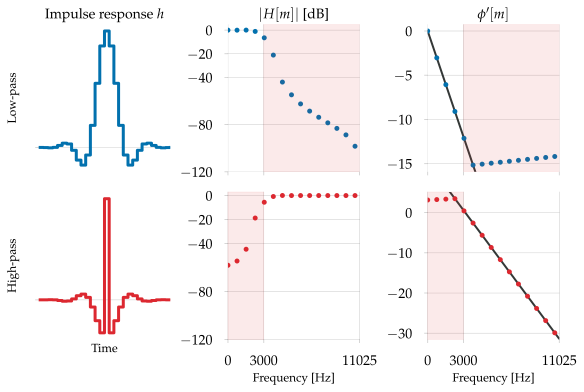

In [344]:
fs = 22050
f_cutoff = 3000
order = 4 * fs // f_cutoff

h_low = scipy.signal.firwin(order, f_cutoff, window='hann', pass_zero='lowpass', fs=fs)
h_high = scipy.signal.firwin(order, f_cutoff, window='hann', pass_zero='highpass', fs=fs)

Hl = np.fft.rfft(h_low)
Hh = np.fft.rfft(h_high)

fig, ax = plt.subplots(ncols=3, nrows=2, sharex='col', figsize=figaspect(2./3))

t = np.arange(order) / fs

ax[0, 0].step(t, h_low, where='post', label='Low-pass')
ax[1, 0].step(t, h_high, where='post', label='High-pass', color=colors[1])

freqs = np.fft.rfftfreq(order, 1/fs)

lp_phase = np.unwrap(np.angle(Hl))
hp_phase = np.unwrap(np.angle(Hh))

ax[0, 1].plot(freqs, 20 * np.log10(np.abs(Hl) + 1e-6), linestyle='', marker='.')
ax[1, 1].plot(freqs, 20 * np.log10(np.abs(Hh) + 1e-6), linestyle='', marker='.', color=colors[1])
ax[0, 1].axvspan(f_cutoff, fs/2, zorder=10, color=colors[1], alpha=0.1)
ax[1, 1].axvspan(0, f_cutoff, color=colors[1], zorder=10, alpha=0.1)
ax[0, 2].plot(freqs, lp_phase, linestyle='', marker='.')
ax[0, 2].axline((freqs[0], lp_phase[0]), xy2=(freqs[1], lp_phase[1]), linewidth=2, color=colors[3], zorder=-1)
ax[1, 2].plot(freqs, hp_phase, linestyle='', marker='.', color=colors[1])
ax[1, 2].axline((freqs[-1], hp_phase[-1]), xy2=(freqs[-2], hp_phase[-2]), linewidth=2, color=colors[3], zorder=-1)
ax[0, 2].axvspan(f_cutoff, fs/2, zorder=10, color=colors[1], alpha=0.1)
ax[1, 2].axvspan(0, f_cutoff, color=colors[1], zorder=10, alpha=0.1)
    
ax[0, 0].set(ylabel='Low-pass')
ax[1, 0].set(ylabel='High-pass')
for _ in range(2):
    ax[_, 0].set(yticks=[0], yticklabels=[], )
    ax[_, 1].set(yticks=[0, -20, -40, -80, -120])

ax[0, 0].set(title='Impulse response $h$', xticks=[])
ax[0, 1].set(title='$|H[m]|$ [dB]')
ax[0, 2].set(title=r"$\phi'[m]$")
ax[1, 0].set(xlabel='Time', xticks=[])
ax[1, 1].set(xlabel='Frequency [Hz]', xticks=[0, f_cutoff, fs/2])
ax[1, 2].set(xlabel='Frequency [Hz]', xticks=[0, f_cutoff, fs/2])


glue('group-delay-plot', fig, display=False)

```{glue:figure} group-delay-plot
:name: group-delay-plot
Two FIR filters are shown (**left column**), along with their frequency response $|H[m]|$ (**center column**) and unwrapped phase spectrum $\phi'[m]$ (**right column**).
Shaded regions correspond to the stop-bands of the filters in the frequency domain.
**Top row**: a low-pass filter with $f_c=3000$ Hz.
**Bottom row**: a high-pass filter with $f_c=3000$ Hz.
Neither filter has completely linear phase response, but both are linear when restricted to the pass band, as indicated by the solid line.
```

Unlike the delay filters depicted in {numref}`phase-unwrap`, these filters do not have a strictly linear response.
In both cases, the unwrapped phase $\phi'[m]$ has a sharp bend near the cutoff frequency $f_c$, where a strictly linear phase response would continue in the same direction.

However, if we restrict attention to the *pass band* of the filters, they both have linear phase response, as indicated by the solid lines in {numref}`group-delay-plot`.
The non-linear part of the phase response is limited to the stop band, **and this is fine!**
Frequencies in the stop band should be attenuated (and ideally, inaudible), and even if phase distortion happens there, it won't matter because we won't hear it.

For this reason, it is typically sufficient to have linear phase only in the pass band of a filter, and it is common to refer to such filters as having linear phase, even if their entire phase response is technically non-linear.

## Summary

In this section, we've seen how to analyze the phase spectrum of FIR filters.
This lead to the definition of *group delay*, which allows us to determine A) if a filter is non-linear, and B) how much delay a filter will apply to a signal.

Practically speaking, the filters we've covered in this chapter (window method and Parks-McClellan) are designed to have linear phase in their pass-bands, so subsequent analysis is not strictly necessary to determine linearity.
That said, the method demonstrated above can still be useful if you need to infer the delay of a given filter.

In the next chapter, we will introduce *infinite* impulse response filters, which generally will not have linear phase.
Understanding group delay in that setting will be much more important, so it's a good idea to get some practice with the method in the FIR setting first!